In [48]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA

In [6]:
df = pd.read_excel('us_macro_quarterly.xlsx',engine='openpyxl')

/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [7]:
df.head()

,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
0,1957:01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1,1957:02,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
2,1957:03,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
3,1957:04,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
4,1958:01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667


In [10]:
def parse_date(data):
    # quarter is in {01,02,03,04}
    year, quarter = data.split(':')
    month = (int(quarter) - 1) * 3 + 1
    s = f"{year}-{month}"
    return datetime.strptime(s, "%Y-%m")

In [11]:
df['Date'] = df['Unnamed: 0'].apply(parse_date)

In [12]:
df.head()

,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL,Date
0,1957:01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667,1957-01-01
1,1957:02,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333,1957-04-01
2,1957:03,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333,1957-07-01
3,1957:04,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000,1957-10-01
4,1958:01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667,1958-01-01


In [13]:
df.set_index(df['Date'], inplace=True)
df.drop(['Date','Unnamed: 0'], axis=1, inplace=True)

In [14]:
df.index.freq = 'QS'

In [15]:
df.head()

,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
Date,,,,,,,,,
1957-01-01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1957-04-01,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
1957-07-01,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
1957-10-01,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
1958-01-01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667


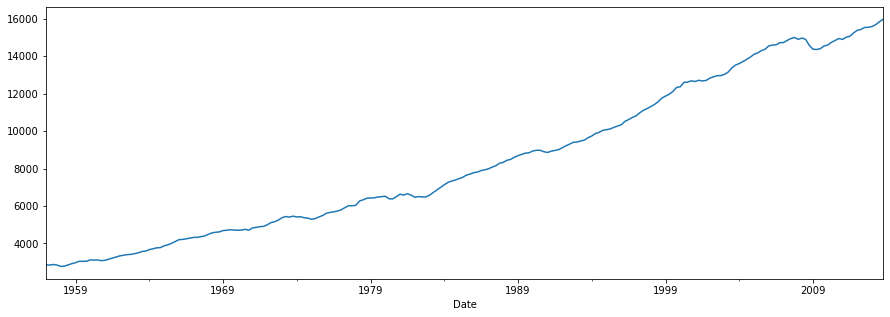

In [17]:
# GDP
df['GDPC96'].plot(figsize=(15,5));

In [23]:
df['GDPGrowth'] = np.log(df['GDPC96']).diff()

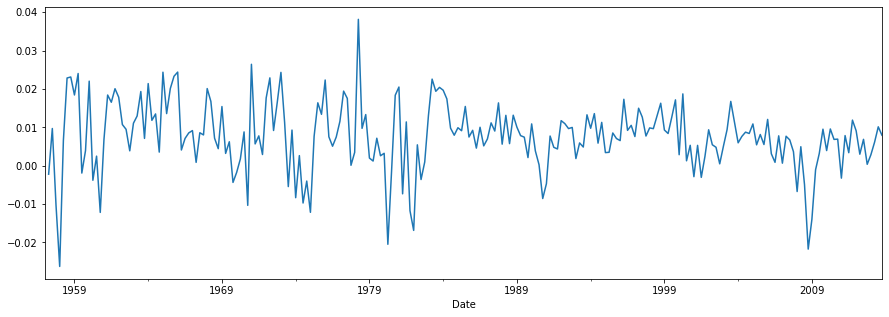

In [24]:
df['GDPGrowth'].plot(figsize=(15,5));

In [25]:
df['TSpread'] = df['GS10'] - df['TB3MS']

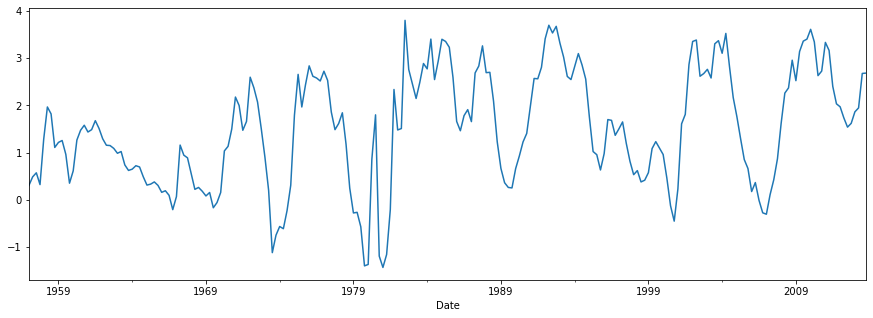

In [26]:
df['TSpread'].plot(figsize=(15,5));

In [27]:
cols = ['GDPGrowth','TSpread']

In [28]:
df1 = df.iloc[1:][cols].copy()

In [29]:
Ntest = 12
train = df1.iloc[:-Ntest]
test = df1.iloc[-Ntest:]

In [30]:
train_idx = df1.index <= train.index[-1]
test_idx = ~train_idx

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train[cols] = scaler.fit_transform(train)
test[cols] = scaler.fit_transform(test)

/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a 

In [33]:
df1.loc[train_idx, :] = train
df1.loc[test_idx, :] = test

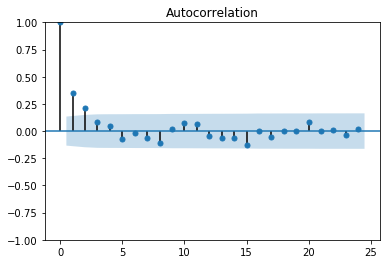

In [34]:
plot_acf(train['GDPGrowth']);

/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


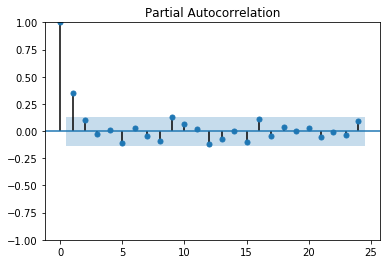

In [35]:
plot_pacf(train['GDPGrowth']);

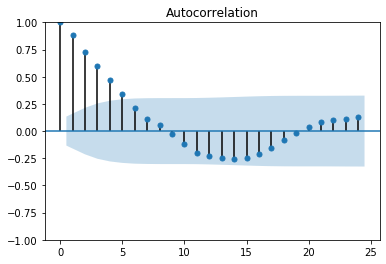

In [37]:
plot_acf(train['TSpread']);

/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


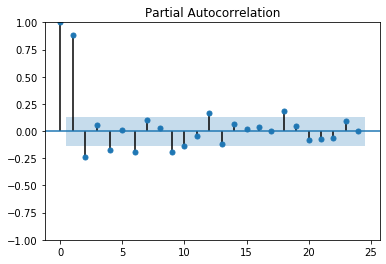

In [38]:
plot_pacf(train['TSpread']);

In [39]:
adfuller(train['GDPGrowth'])

(-7.4466396546255815,
 5.814896580913804e-11,
 1,
 213,
 {'1%': -3.461429147102264,
  '5%': -2.875206950587861,
  '10%': -2.5740544497344002},
 512.854231063742)

In [41]:
adfuller(train['TSpread'])

(-4.0010207954755845,
 0.0014051754907493364,
 12,
 202,
 {'1%': -3.4631437906252636,
  '5%': -2.8759570379821047,
  '10%': -2.574454682874228},
 246.36949884218734)

In [42]:
p = 18
q = 1

In [43]:
t0 = datetime.now()
model = VARMAX(train, order=(p,q))
res = model.fit(maxiter=100)
print("Duration:", datetime.now() - t0)

/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/Users/maria/opt/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Duration: 0:00:49.589515


In [45]:
fcast = res.get_forecast(Ntest)

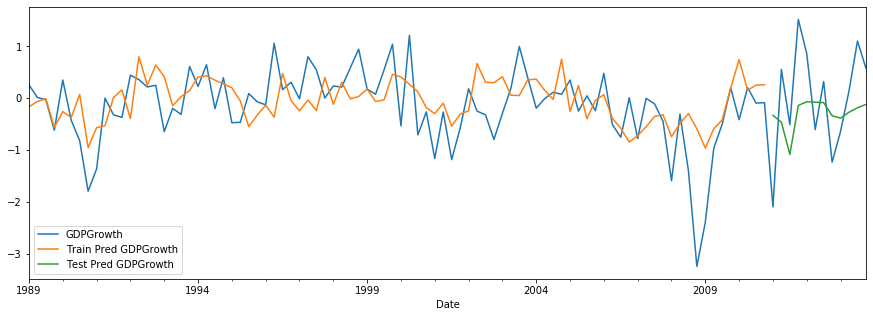

In [46]:
df1.loc[train_idx, 'Train Pred GDPGrowth'] = res.fittedvalues['GDPGrowth']
df1.loc[test_idx, 'Test Pred GDPGrowth'] = fcast.predicted_mean['GDPGrowth']
plot_cols = ['GDPGrowth','Train Pred GDPGrowth', 'Test Pred GDPGrowth']
df1.iloc[-100:][plot_cols].plot(figsize=(15,5));

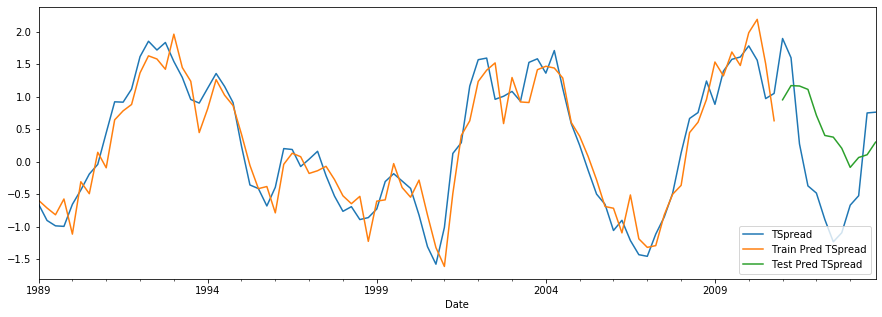

In [47]:
df1.loc[train_idx, 'Train Pred TSpread'] = res.fittedvalues['TSpread']
df1.loc[test_idx, 'Test Pred TSpread'] = fcast.predicted_mean['TSpread']
plot_cols = ['TSpread','Train Pred TSpread', 'Test Pred TSpread']
df1.iloc[-100:][plot_cols].plot(figsize=(15,5));

In [49]:
for col in cols:
    y_true = df1.loc[train_idx, col]
    y_pred = res.fittedvalues[col]
    print("Train R^2:", r2_score(y_true, y_pred))

    y_true = df1.loc[test_idx, col]
    y_pred = fcast.predicted_mean[col]
    print("Test R^2:", r2_score(y_true, y_pred))

Train R^2: 0.2766187519842547
Test R^2: 0.02156221923658208
Train R^2: 0.8736705317392693
Test R^2: -0.06703092560492485


VAR

In [50]:
model = VAR(train)

In [51]:
lag_order_results = model.select_order(maxlags=20)
lag_order_results.selected_orders

{'aic': 10, 'bic': 1, 'hqic': 2, 'fpe': 10}

In [52]:
results = model.fit(maxlags=20, ic='aic')

In [53]:
lag_order = results.k_ar

In [54]:
prior = train.iloc[-lag_order:][cols].to_numpy()
fcast = results.forecast(prior, Ntest)

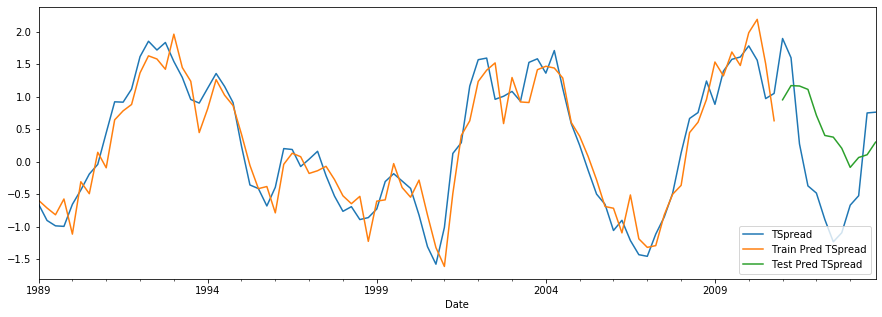

In [57]:
df1.loc[train_idx, 'Train Pred GDPGrowth'] = results.fittedvalues['GDPGrowth']
df1.loc[test_idx, 'Test Pred GDPGrowth'] = fcast[:,0]
polt_cols = ['GDPGrowth','Train Pred GDPGrowth','Test Pred GDPGrowth']
df1.iloc[-100:][plot_cols].plot(figsize=(15,5));

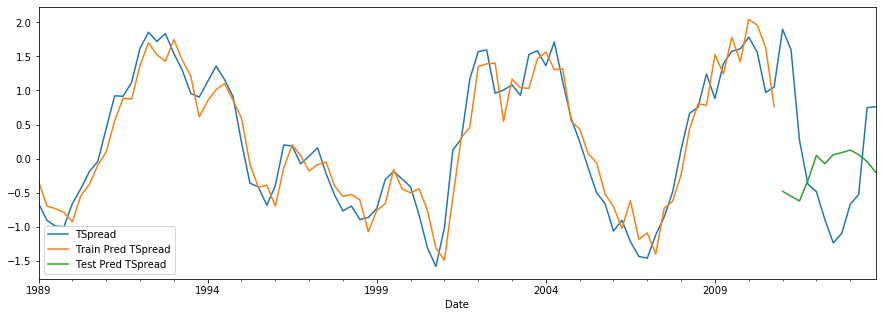

In [58]:
df1.loc[train_idx, 'Train Pred TSpread'] = results.fittedvalues['TSpread']
df1.loc[test_idx, 'Test Pred TSpread'] = fcast[:,0]
polt_cols = ['TSpread','Train Pred TSpread','Test Pred TSpread']
df1.iloc[-100:][plot_cols].plot(figsize=(15,5));

In [59]:
y_pred = df1.loc[train_idx,'Train Pred GDPGrowth']
y_true = df1.loc[train_idx, 'GDPGrowth']
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]
print("GDPGrowth Train R^2:", r2_score(y_true,y_pred))

y_pred = df1.loc[test_idx,'Test Pred GDPGrowth']
y_true = df1.loc[test_idx, 'GDPGrowth']
print("GDPGrowth Test R^2:", r2_score(y_true,y_pred))

GDPGrowth Train R^2: 0.2569812409739456
GDPGrowth Test R^2: -0.043148231655072644


In [60]:
y_pred = df1.loc[train_idx,'Train Pred TSpread']
y_true = df1.loc[train_idx, 'TSpread']
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]
print("TSpread Train R^2:", r2_score(y_true,y_pred))

y_pred = df1.loc[test_idx,'Test Pred TSpread']
y_true = df1.loc[test_idx, 'TSpread']
print("TSpread Test R^2:", r2_score(y_true,y_pred))

TSpread Train R^2: 0.8581031996649262
TSpread Test R^2: -0.46857450832436953


In [61]:
for col in cols:
    model = ARIMA(train[col], order=(p,0,q))
    res = model.fit()
    fcast = res.get_forecast(Ntest)
    y_train = df1.loc[train_idx,col]
    y_test = df1.loc[test_idx,col]
    print(f"{col} Train R^2:", r2_score(y_train, res.fittedvalues))
    print(f"{col} Test R^2:", r2_score(y_test, fcast.predicted_mean))

GDPGrowth Train R^2: 0.20569397171286652
GDPGrowth Test R^2: -0.0670615118323068
TSpread Train R^2: 0.8332486531724252
TSpread Test R^2: 0.4120237094827245
